<a href="https://colab.research.google.com/github/harshithgowdakc/NYC-Taxi-Data/blob/main/NYC_Taxi_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Project CPG/NYC Taxi Data.csv')

In [26]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435


In [27]:
data.shape 

(1458644, 11)

In [28]:
#Check count of unique id's in the dataset
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

There are 1458644 unique id's in Training dataset, which is equal to the number of records


In [29]:
#Check for NaN values
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [30]:
#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [31]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.weekday
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [32]:
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [33]:
#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [34]:
#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.trip_duration/3600))

In [35]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [36]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

In [37]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,...,0,1,0,0,0,0,0,0,0,0


In [38]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

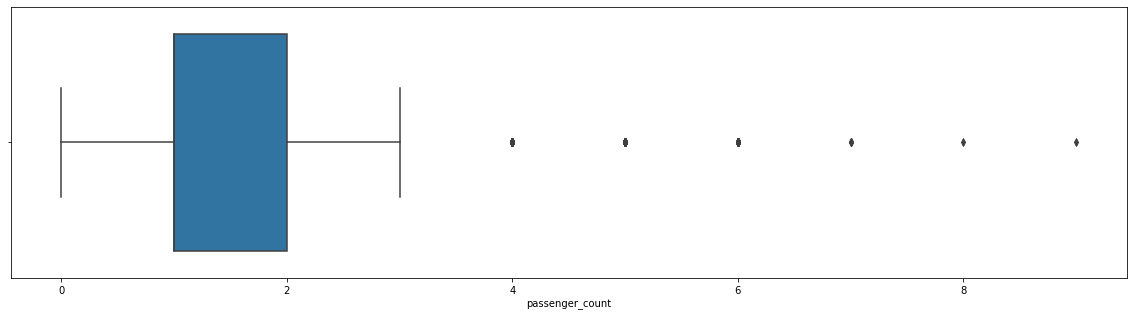

In [39]:
plt.figure(figsize = (20,5))
sns.boxplot(data.passenger_count)
plt.show()

In [40]:
data.passenger_count.describe()

count   1458644.00
mean          1.66
std           1.31
min           0.00
25%           1.00
50%           1.00
75%           2.00
max           9.00
Name: passenger_count, dtype: float64

In [42]:
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

In [43]:
data = data[data.passenger_count <= 6]

In [44]:
data.passenger_count.value_counts()


1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

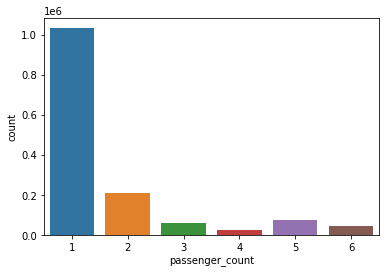

In [45]:
sns.countplot(data.passenger_count)
plt.show()

### Vendor

Here we analyze taxi data only for the 2 vendors which are listed as 1 and 2 in the datset.

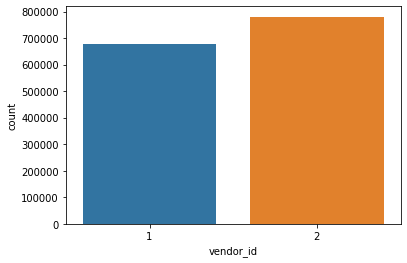

In [46]:
sns.countplot(data.vendor_id)
plt.show()

Though both the vendors seems to have almost equal market share. But Vendor 2 is evidently more famous among the population as per the above graph.

### Distance

Let's now have a look on the distribution of the distance across the different types of rides.


In [47]:
print(data.distance.describe())

count   1458639.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.09
75%           3.88
max        1240.91
Name: distance, dtype: float64


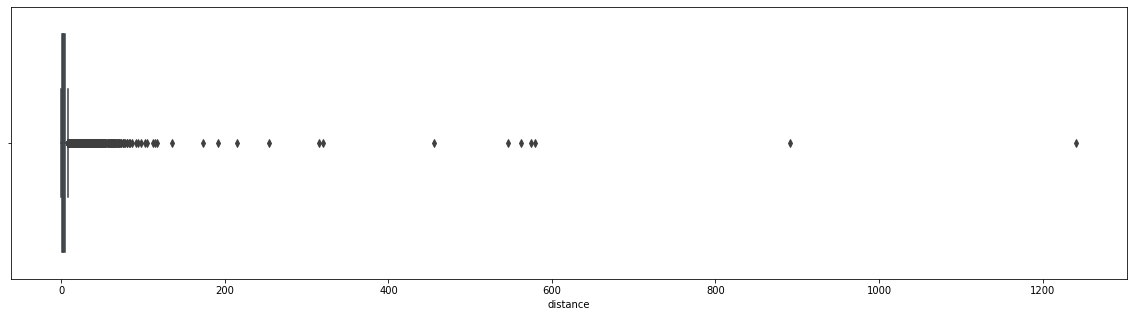

In [48]:
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()

**Interesting find:**
There some trips with over 100 km distance.

Some of the trips distance value is 0 km.

**Observations:**

mean distance travelled is approx 3.5 kms.

standard deviation of 4.3 which shows that most of the trips are limited to the range of 1-10 kms.

In [49]:
print("There are {} trip records with 0 km distance".format(data.distance[data.distance == 0 ].count()))

There are 5895 trip records with 0 km distance


In [50]:
data[data.distance == 0 ].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.98,40.77,-73.98,40.77,N,...,0,1,0,0,0,0,0,0,0,0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.96,40.78,-73.96,40.78,N,...,0,0,1,0,0,0,0,0,0,0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.81,40.69,-73.81,40.69,N,...,1,0,0,0,0,0,1,0,0,0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.79,40.65,-73.79,40.65,N,...,0,1,0,0,0,0,0,0,0,0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.21,40.82,-74.21,40.82,N,...,0,1,0,0,0,0,0,0,0,0


**Observations**

Around 6K trip record with distance equal to 0. Below are some possible explanation for such records.



1.   Customer changed mind and cancelled the journey just after accepting it.
2.   Software didn't recorded dropoff location properly due to which dropoff location is the same as the pickup location.
3.   Issue with GPS tracker while the journey is being finished.
4.   Driver cancelled the trip just after accepting it due to some reason. So the trip couldn't start
5.   Or some other issue with the software itself which a technical guy can explain

There is some serious inconsistencies in the data where drop off location is same as the pickup location. We can't think off imputing the distance values considering a correlation with the duration because the dropoff_location coordinates would not be inline with the distance otherwise. We will look more to it in bivariate analysis with the Trip duration.

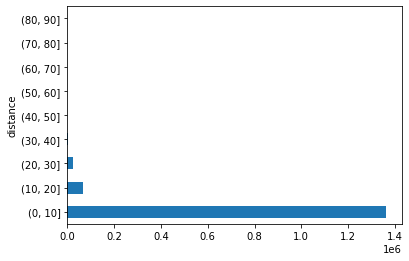

In [51]:
data.distance.groupby(pd.cut(data.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.show()

From the above observation it is evident that most of the rides are completed between 1-10 Kms with some of the rides with distances between 10-30 kms. Other slabs bar are not visible because the number of trips are very less as compared to these slabs

### Trip duration

In [52]:
data.trip_duration.describe()

count   1458639.00
mean        959.50
std        5237.44
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64

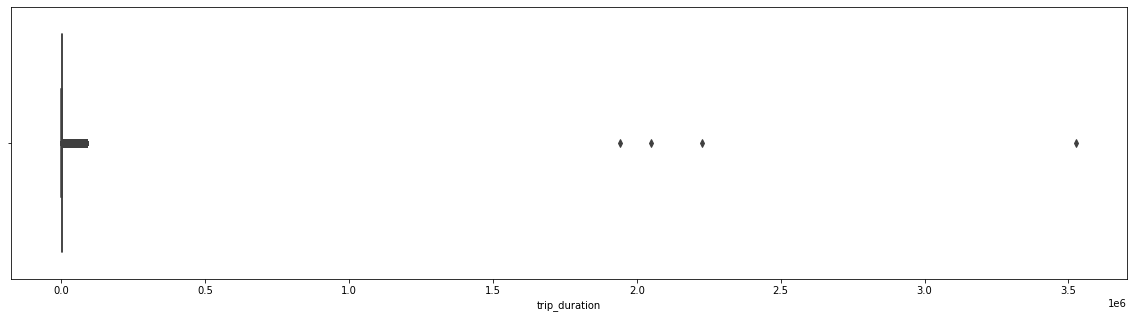

In [53]:
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

Interesting find:
Some trip durations are over 100000 seconds which are clear outliers and should 
*   Some trip durations are over 100000 seconds which are clear outliers and should be removed.

Observations:

*   There are some durations with as low as 1 second. which points towards trips with 0 km distance.
*   Major trip durations took between 10-20 mins to complete.
*   Mean and mode are not same which shows that trip duration distribution is skewed towards right.

Let's analyze more

In [54]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446308
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
                       ...   
(3506401, 3510001]          0
(3510001, 3513601]          0
(3513601, 3517201]          0
(3517201, 3520801]          0
(3520801, 3524401]          0
Name: trip_duration, Length: 979, dtype: int64

Observations:

*   There are some trips with more than 24 hours of travel duration i.e. 86400 seconds. Which might have occured on weekends for the outstation travels.
*   Major chunk of trips are completed within an interval of 1 hour with some good numbers of trips duration going above 1 hour.

Let's look at those trips with huge duration, these are outliers and should be removed for the data consistency.

In [55]:
data[data.trip_duration > 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.79,40.64,-73.96,40.77,N,...,0,1,0,0,0,0,0,0,0,0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.92,40.74,-73.98,40.76,N,...,0,0,1,0,0,0,0,0,0,0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.98,40.74,-73.99,40.73,N,...,0,1,0,0,0,0,0,0,0,0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.78,40.65,-73.98,40.75,N,...,0,1,0,0,0,0,0,0,0,0


Observations:

*   These trips ran for more than 20 days, which seems unlikely by the distance travelled.
*   All the trips are taken by vendor 1 which points us to the fact that this vendor might allows much longer trip for outstations.
*   All these trips are either taken on Tuesday's in 1st month or Saturday's in 2nd month. There might be some relation with the weekday, pickup location, month and the passenger.
*   But they fail our purpose of correct prediction and bring inconsistencies in the algorithm calculation.

We should get rid of them for the sake of data consistency. Those are black swans !!

In [56]:
data = data[data.trip_duration <= 86400]

Let's visualize the number of trips taken in slabs of 0-10, 20-30 ... minutes respectively

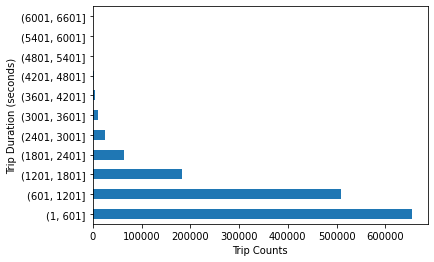

In [57]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs. Let's move ahead to next feature.

### Speed

Speed is a function of distance and time. Let's visualize speed in different trips.

Maximum speed limit in NYC is as follows:

*   25 mph in urban area i.e. 40 km/h

*   65 mph on controlled state highways i.e. approx 104 km/h
 

In [58]:
data.speed.describe()

count   1458635.00
mean         14.42
std          14.98
min           0.00
25%           9.12
50%          12.79
75%          17.84
max        9274.85
Name: speed, dtype: float64

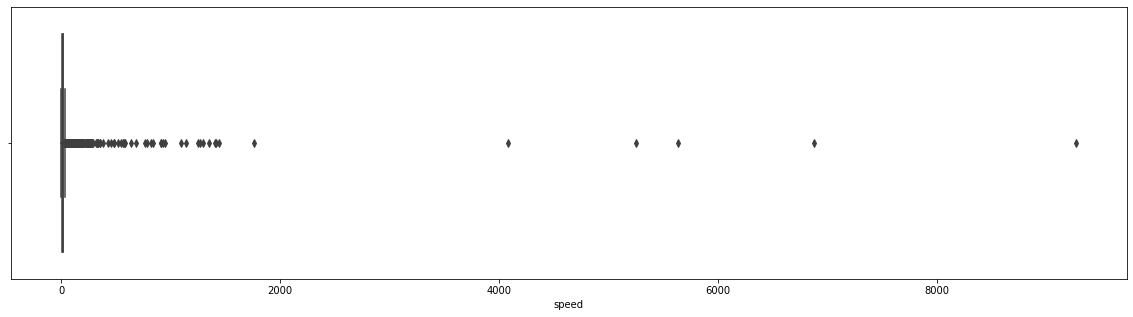

In [59]:
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

Interesting find:

*   Many trips were done at a speed of over 200 km/h. Going SuperSonic..!!

Let's remove them and focus on the trips which were done at less than 104 km/h as per the speed limits

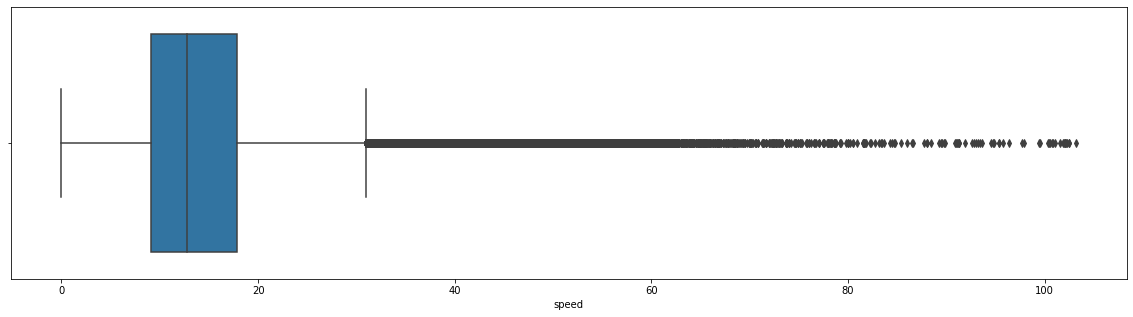

In [60]:
data = data[data.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

Observations:


*   Trips over 30 km/h are being considered as outliers but we cannot ignore them because they are well under the highest speed limit of 104 km/h on state controlled highways.
*   Mostly trips are done at a speed range of 10-20 km/h with an average speed of around 14 km/h.

Let's take a look at the speed range ditribution with the help of graph.

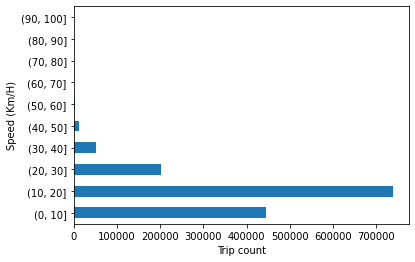

In [61]:
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

It is evident from this graph what we thought off earlier i.e. most of the trips were done at a speed range of 10-20 km/H.

### Store_and_fwd_flag

This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

In [62]:
data.flag_Y.value_counts(normalize=True)

0   0.99
1   0.01
Name: flag_Y, dtype: float64

Observations:


*   List item


1.   List item

1.   List item
2.   List item


2.   List item


*   List item



In [63]:
data.flag_Y.value_counts()

0    1450433
1       8044
Name: flag_Y, dtype: int64

Above result shows that around 8K trips had to store the flag and then report to the server when the connection was established. Let's check the respective distribution with the vendors for the offline trips.

In [64]:
data.vendor_id[data.flag_Y == 1].value_counts()

1    8044
Name: vendor_id, dtype: int64

Observations:

In [65]:
data[data.flag_Y == 1]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
348,id1633648,1,2016-06-20 14:19:16,2016-06-20 14:34:34,1,-73.98,40.75,-73.95,40.77,Y,...,0,1,0,0,0,0,0,0,0,0
491,id2042535,1,2016-02-12 12:36:38,2016-02-12 12:47:07,1,-73.98,40.76,-73.99,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
610,id0909228,1,2016-05-08 15:02:28,2016-05-08 15:17:54,1,-73.99,40.74,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0
774,id3697489,1,2016-01-13 13:53:29,2016-01-13 14:08:21,1,-73.95,40.78,-73.98,40.78,Y,...,0,1,0,0,0,0,0,0,0,0
846,id1026973,1,2016-06-25 21:53:30,2016-06-25 22:05:27,1,-73.98,40.76,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457556,id2229555,1,2016-01-22 19:05:50,2016-01-22 19:27:09,1,-73.87,40.77,-73.93,40.73,Y,...,0,1,0,0,0,0,0,0,0,0
1457670,id0510811,1,2016-04-07 21:14:30,2016-04-07 21:51:38,1,-73.78,40.64,-73.98,40.67,Y,...,0,1,0,0,0,0,0,0,0,0
1457897,id3209015,1,2016-03-20 18:49:55,2016-03-20 19:09:25,1,-73.99,40.71,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
1458060,id1371896,1,2016-03-28 11:45:49,2016-03-28 12:21:45,1,-73.97,40.76,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0


Observations



1.   List item

*   List item
*   List item


2.   List item



### Total trips Per Hour

Let's take a look at the distribution of the pickups across the 24 hour time scale.

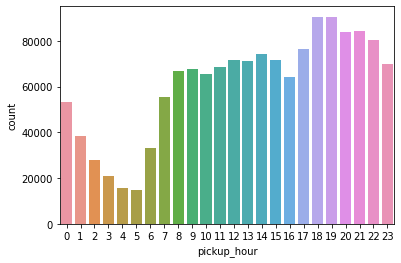

In [66]:
sns.countplot(data.pickup_hour)
plt.show()

Observation

*   It's inline with the general trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.

### Total trips per weekday

Let's take a look now at the distribution of taxi pickups across the week.

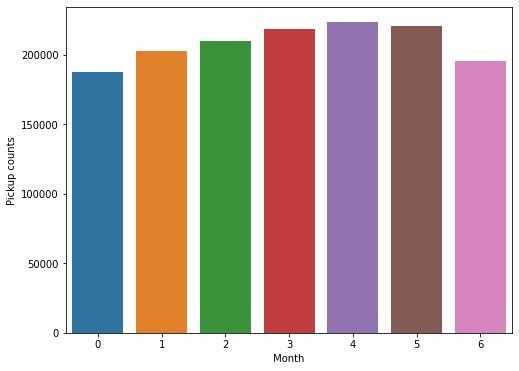

In [67]:
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

Observation
*   Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

Let's drill down more to see the hourwise pickup pattern across the week

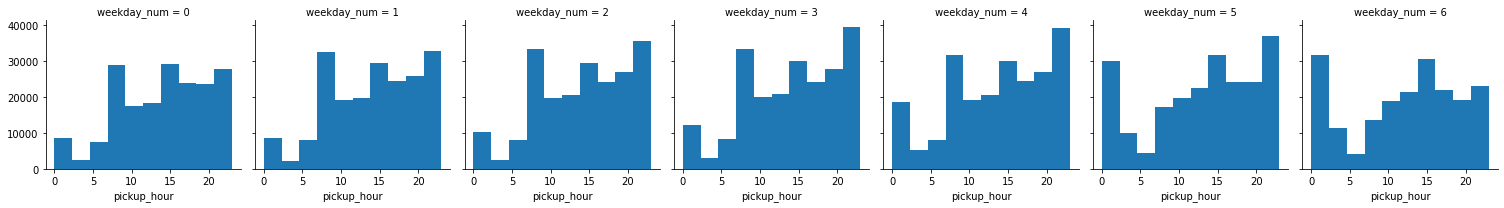

In [68]:
n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

Interesting find:
*   Taxi pickups increased in the late night hours over the weekend possibly due to more outstation rides or for the late night leisures nearby activities.


*   Early morning pickups i.e before 5 AM have increased over the weekend in comparison to the office hours pickups i.e. after 7 AM which have decreased due to obvious reasons.

*   Taxi pickups seems to be consistent across the week at 15 Hours i.e. at 3 PM.

### Total trips per month

Let's take a look at the trip distribution across the months to understand if there is any diffrence in the taxi pickups in different months

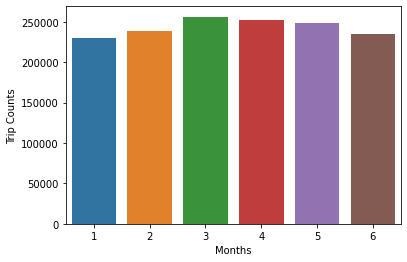

In [69]:
sns.countplot(data.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

Quite a balance across the months here. It could have been more equivalent if we wouldn't have removed the inconsistent records in our study of the univariate analysis

## **Bivariate Analysis**

Bivariate analysis is used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.

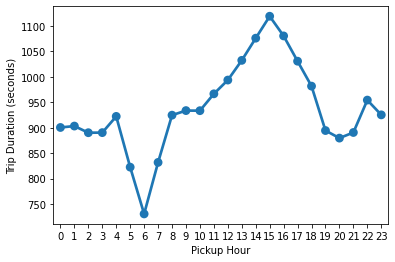

In [70]:
group1 = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

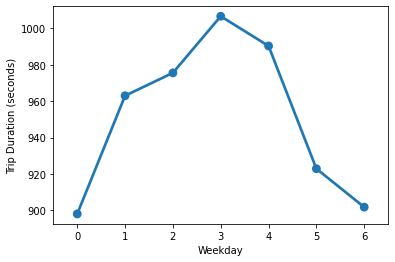

In [71]:
group2 = data.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

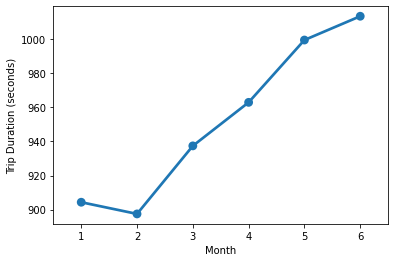

In [72]:
group3 = data.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

### Trip duration per vendor

We can also look at the average difference between the trip duration for each vendor. However we do know that vendor 2 has larger share of the market. Let's visualize.

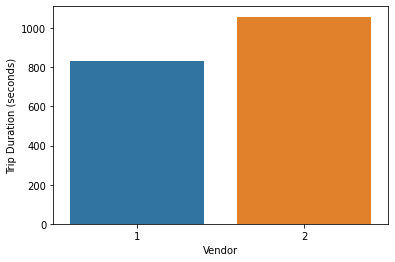

In [73]:
group4 = data.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by approx 200 seconds i.e. atleast 3 minutes per trip.

### Trip duration v/s Flag

Let's visualize if there is any effect of flag setting on the trip duration?

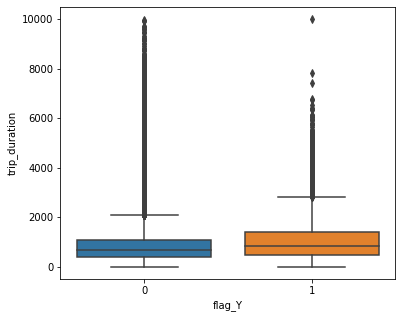

In [74]:
plt.figure(figsize = (6,5))
plot_dur = data.loc[(data.trip_duration < 10000)]
sns.boxplot(x = "flag_Y", y = "trip_duration", data = plot_dur)
plt.show()

Observations:

*   Trip durations scale is less for the trips where the flag is set i.e. the trip details are stored before sending it to the server.
*   Trip duration outliers are also less for the trips with flag 'Y' as compared the trips with flag 'N'.
*   Trip duration is longer for the trips where the flag is not set.
*   Inter quartile range of trip duration is more for the trips with the flag 'Y' as compared to the trips with flag 'N' but the median value is almost equal for both.

### Distance per hour

Now, let us check how the distance is distributed against different variables. We know that trip distance must be more or less proportional to the trip duration if we ignore general traffic and other stuff on the road. Let's visualize this for each hour now.

Since we have already done the outlier analysis for this variable as well. We can take the mean as aggregate measure for our visualizations.

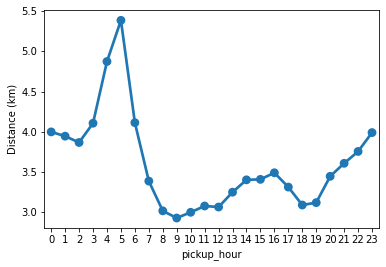

In [75]:
group5 = data.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

Observations:


*   Trip distance is highest during early morning hours which can account for some things like:
    1.   Outstation trips taken during the weekends.

    2.   Longer trips towards the city airport which is located in the outskirts of the city.



*   Trip distance is fairly equal from morning till the evening varying around 3 - 3.5 kms.

*   It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.

In [77]:
pd.set_option('display.max_columns', None)

### Distance per weekday

Let's analyze the average trip distance covered on each day of the week.

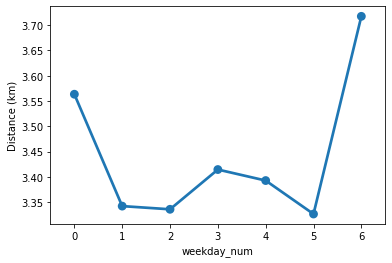

In [80]:
group6 = data.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

### Distance per month

Now we will look at the average trip distance covered per month.

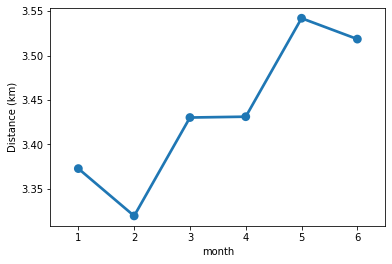

In [81]:
group6 = data.groupby('month').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

Here also the distibution is almost equivalent, varying mostly around 3.5 km/h with 5th month being the highest in the average distance and 2nd month being the lowest.

Distance per vendor

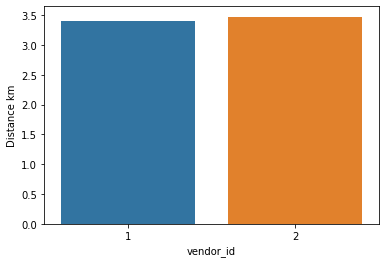

In [88]:
group8 = data.groupby('vendor_id').distance.mean()
sns.barplot(group8.index, group8.values)
plt.ylabel("Distance km")
plt.show()

This is more or less same picture with both the vendors. Nothing more to analyze in this.

### Distance v/s Flag

Let's visualize if there is any effect of Flag setting on the distance covered in the trips

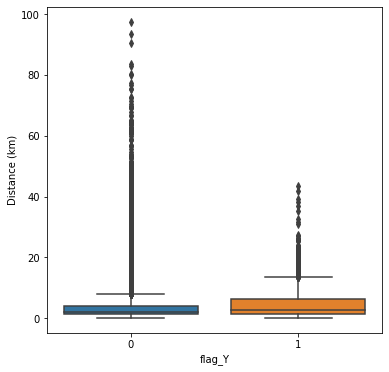

In [96]:
plt.figure(figsize = (6,6))
plot_dist = data.loc[(data.distance < 100)]
sns.boxplot(x = "flag_Y", y = "distance", data = plot_dist)
plt.ylabel('Distance (km)')
plt.show()

Observations:


*   We can see almost similar results like the one observed in the Trip duration v/s Flag analysis.

*   Only two major difference can be seen here.
    1.   Interquartile range of distance is almost twice for Flag 'Y' trips as compared to the Flag 'N' trips

    2.   Median value is much different in both the case as well.

Which points us to the fact that range of distance and trip duration for the Flag 'Y' trips is much more limited and confined as compared with the flag 'N' trips and this also resulted in much less number of outliers for Flag 'Y' trips.

### Distance v/s Trip duration

Let's visualize the relationship between Distance covered and respective trip duration.

In [97]:
data.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hour,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,0,3,0,17,1.50,11.86,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,6,6,6,0,1.81,9.80,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


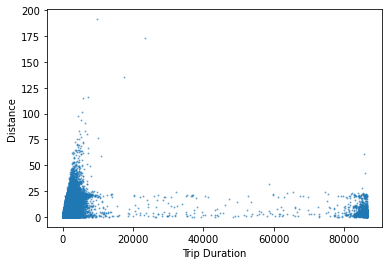

In [107]:
plt.scatter(data.trip_duration, data.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

Interesting find:


*   There are lots of trips which covered negligible distance but clocked more than 20,000 seconds in terms of the Duration.

*   Initially there is some proper correlation between the distance covered and the trip duration in the graph. but later on it all seems uncorrelated.

*   There were few trips which covered huge distance of approx 200 kms within very less time frame, which is unlikely and should be treated as outliers.


Let's focus on the graph area where distance is < 50 km and duration is < 1000 seconds.
